In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
block_path = '/home/AD/tsheehan/data/Pen01_Lft_AP750_ML1750__Site01_Z1100__B952_cat_P01_S01_1'
from ephys import core
from ephys import clust
from ephys import events
from ephys import rasters
import os
import scipy as sp
import scipy.io.wavfile as wf
import scipy.signal as signal
#import pywt # wavelet toolbox

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
# want to get STA and STC for example dataset
# load response (neurons), stimulus (wav files to spectrograms)
clusters = core.load_clusters(block_path) # pandas - DataFrame
neurons = (
    clusters[clusters.quality.isin(['Good'])]
    .sort_values(['quality','cluster'],ascending=False)
    .reset_index()
)
trials = events.load_trials(block_path)
stim_labels = list(set(trials.stimulus))
spikes = core.load_spikes(block_path)


In [5]:
fs = 44100
stim_labels[0]
stim_loc = block_path + '/stims'
files = os.listdir(stim_loc)
songs = []
spects = []
freqs = []
times = []
noverlap = 512
nperseg = 1024

for i in range(len(stim_labels)):
    this_label = stim_labels[i] +'.wav'
    my_song = [x for x in files if x in this_label]
    if my_song:
        this_song = wf.read(stim_loc + '/' + my_song[0])
        songs.append((this_song[1]))    
    
    my_spect = signal.spectrogram(songs[i],fs =fs, nperseg = nperseg,noverlap = noverlap)
    spects.append(my_spect[2])
    freqs.append(my_spect[0])
    times.append(my_spect[1])
    
    print(len(this_song[1]))

2892045
2961304
2674358
2400000
2400000


In [6]:
import get_STA
reload(get_STA)
stim_use = 2
neuron_ind = 12
this_label = stim_labels[stim_use]
these_trials = trials[trials['stimulus']==this_label]
this_st = these_trials['time_samples'].values
this_end = these_trials['stimulus_end'].values
dd = this_end-this_st

my_cluster = neurons['cluster'][neuron_ind]
my_spikes = spikes[spikes['cluster']==my_cluster]
my_times = my_spikes['time_samples']

#get_STA_p.get_STA_from_points(my_times,this_end,dd[0],songs[stim_use],50)
#tmp  = get_STA_p.get_STA_mult_song(my_times,songs,trials)
#get_STA_p.plot_STA_mult_song(my_times,songs,trials,[],1)

#get_STA_p.plot_STA_mult_neuron(neurons,spikes,songs,trials,40)
s_view = 2
c_lim = (-60,60)
#get_STA_p.visualize_reduced_spectrogram(songs[s_view],c_lim)
#get_STA_p.visualize_full_spectrogram(songs[s_view],c_lim)
ratio = get_STA.get_ds_rate(songs)
spk_times = my_spikes['time_samples'].values


(2892045, 3227, 896)
(2961304, 3304, 896)
(2674358, 2984, 896)
(2400000, 2678, 896)
(2400000, 2678, 896)


(30472, 16, 50)


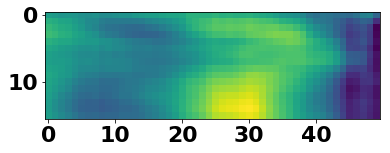

In [105]:
import get_STA
reload(get_STA)
song_names = list(set(trials['stimulus']))
song_mask, song_ramp = get_STA.get_song_mask(trials,ratio/2)


STA,f = get_STA.get_sta(spk_times,songs,song_mask,song_ramp,50)
mSTA = np.mean(STA,0)
plt.imshow(mSTA)
print(np.shape(STA))
#STA[1]
#ind = 1000
#print(np.shape(STA[ind]),STA[ind])
# STA

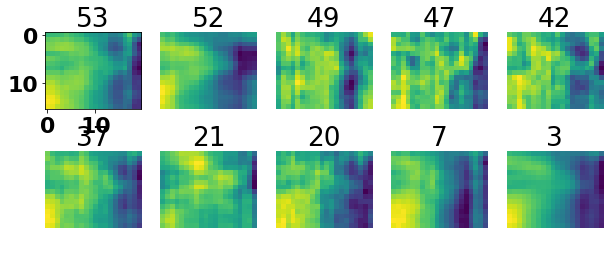

In [106]:
import get_STA
reload(get_STA)
get_STA.visualize_some_stas(neurons,spikes,songs,song_mask,song_ramp,20)


In [77]:
np.abs(-5)

5

In [74]:
song_use = 0
PSTH = get_STA.get_PSTH(spk_times,song_use,song_mask,song_ramp)

tmp = np.unique(song_ramp[song_mask==song_use+1])
np.max(tmp)

3227


KeyboardInterrupt: 

In [40]:
window = 16
quick_spect = get_STA.flat_reduced_spectrogram(songs[song_use],window)
print(np.shape(PSTH),np.shape(quick_spect))
quick_spectT = np.transpose(quick_spect)

(3212, 256)
((3227,), (256, 3212))


In [57]:
import theano
import mner.optimizer
import mner.util.util
import mner.solvers.solvers
import mner.solvers.constraints
import mner.solvers.samplers

s, s_avg, s_std = mner.util.util.zscore_features(quick_spectT)
y = PSTH[window-1:]

jack = 1
njack = 4

# fraction of the data reserved for training and cross-validation (remainder is testing)
train_fraction = 0.7
cv_fraction = 0.2
nsamp = np.shape(s)[0]
ndim = np.shape(s)[1]
print(np.shape(s),ndim)

trainset, cvset, testset, nshift = mner.util.util.generate_dataset_logical_indices(train_fraction, cv_fraction, nsamp, njack)
trainset, cvset, testset = mner.util.util.roll_dataset_logical_indices(trainset, cvset, testset, nshift, jack-1)
datasets = {'trainset': trainset, 'cvset': cvset, 'testset': testset}

# model parameters
rank = 4
cetype = ["UV-linear-insert"]
rtype = ["nuclear-norm"]

# if J is symmetrized using linear constraints, need to set signs of eigenvalues
csigns = np.array([1, -1]*(rank/2))

# set scaling of cost function (for each data set)
fscale = {"trainset": -1, "cvset": -1, "testset": -1}

# choose solver
#solver = mner.solvers.solvers.IPMSolver
solver = mner.solvers.solvers.LBFGSSolver

# fit parameters (note the change for demo_type == 7 below)
factr = 1.0e10
lbfgs = 30


opt = mner.optimizer.Optimizer(y, s, rank, cetype=cetype, rtype=[], solver=solver, datasets=datasets, fscale=fscale, csigns=csigns, lbfgs=lbfgs, precompile=True, compute_hess=False, verbosity=2, iprint=1, factr=factr)


x, ftrain = opt.optimize()

((3212, 256), 256)


In [58]:
a, h, U, V = mner.util.util.vec_to_weights(x, ndim, rank)
#J_real = np.matmul(U,V.T)
V = np.dot(U, np.diag(csigns))

# form J and symmetrize then compute components
Jsym = np.dot(U, V.T)
Jsym = 0.5*(Jsym + Jsym.T)
[u, _, _] = np.linalg.svd(Jsym)

((1281,), (3212,), (3212, 256))


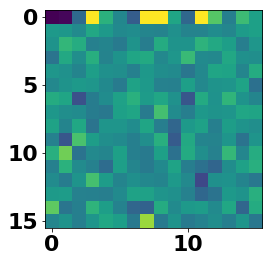

In [62]:
nx = window
ny = 16
cm = .2
plt.imshow(np.reshape(u[:,10], (ny, nx)), aspect='equal', interpolation='none',clim=(-cm, cm))
print(np.shape(x),np.shape(y),np.shape(s))

#plt.colorbar()

In [17]:
print(np.diag(csigns))

[[ 1  0  0  0  0  0]
 [ 0 -1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0 -1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 -1]]


In [63]:
a, h, U, V = mner.util.util.vec_to_weights(x, ndim, rank)
tmp= np.transpose(V)
print(np.shape(U),np.shape(V))
J_real = np.matmul(U,tmp)

((256, 4), ())


TypeError: Object arrays are not currently supported